# Project Proposal Group 15

#### By: Tony Liang, Jack Fan, Minghao Wang

## 1. Introduction

### Below are just instructions to be deleted after finish
*Begin by providing some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal.*

*Clearly state the question you will try to answer with your project. Your question should involve one or more random variables of interest, spread across two or more categories that are interesting to compare. For example, you could consider the annual maxima river flow at two different locations along a river, or perhaps gender diversity at different universities. Of the response variable, identify one location parameter (mean, median, quantile, etc.) and one scale parameter (standard deviation, inter-quartile range, etc.) that would be useful in answering your question. Justify your choices.*

*Identify and describe the dataset that will be used to answer the question. Remember, this dataset is allowed to contain more variables than you need – feel free to drop them!*

*Also, be sure to frame your question/objectives in terms of what is already known in the literature. Be sure to include at least two scientific publications that can help frame your study (you will need to include these in the References section). We have no specific citation style requirements, but be consistent.*

### 1.1 Background information on the topic

Text

### 1.2 The Question 

Text

### 1.3 The Dataset

Text

### 1.4 The Literature 

Text

## 2. Preliminary Results

### 2.0 Libraries and Packages

In [3]:
library(tidyverse)
library(readr)
library(tidyr)
library(dbplyr)
library(lubridate)
library(ggplot2)

### 2.1 Read the data into R

In [4]:
df <- read_csv("../data/crdt-data.csv")
cat("The dimenstion of this dataframe is: ", dim(df)[1], "x", dim(df)[2])
head(df)

Rows: 5320 Columns: 54

-- Column specification ----------------------------------------------------
Delimiter: ","
chr  (1): State
dbl (53): Date, Cases_Total, Cases_White, Cases_Black, Cases_Latinx, Cases_A...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



The dimenstion of this dataframe is:  5320 x 54

Date,State,Cases_Total,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,...,Tests_Latinx,Tests_Asian,Tests_AIAN,Tests_NHPI,Tests_Multiracial,Tests_Other,Tests_Unknown,Tests_Ethnicity_Hispanic,Tests_Ethnicity_NonHispanic,Tests_Ethnicity_Unknown
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20210307,AK,59332,18300,1499,NA,2447,12238,1508,4453,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AL,499819,160347,82790,NA,2273,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AR,324818,207596,50842,NA,2913,1070,3358,1804,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AS,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AZ,826454,308453,25775,244539,11921,40707,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,CA,3501394,546630,111279,1509103,186562,9025,15281,42824,...,9444459,3980518,98894,222513,74171,6354689,18567612,9444459,21633943,18567612


After reading data, we noticed that this raw data is consists of 5320 observations (rows) and 54 variables (columns), whereas there exist many NA values. This suggests that we need to clean and wrangle it into a tidier data to work with, plus, selecting our interest variables. We are interested in estimating proportions of tested positive among selected ethnicities, and categorize them by `Date`, `State`. Hence, we will only keep the following variables:

`Cases_Total`, `Cases_White`, `Cases_Black`, `Cases_Latinx`, `Cases_Asian`, `Date`,`State`. 
<br>
</br>
And for the simplicity of this project, we will assume these data were Missing Completely At Random (MCAR), therefore dropping all NA values. 


### 2.2 Clean and wrangle data into a tidy format

In [5]:
cases_piped <- df %>%
    select(Date, State, Cases_Total:Cases_Asian) %>%
    drop_na()
head(cases_piped)
cat("The dimenstion of cases_piped is: ", 
    dim(cases_piped)[1], "x", dim(cases_piped)[2])

Date,State,Cases_Total,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20210307,AZ,826454,308453,25775,244539,11921
20210307,CA,3501394,546630,111279,1509103,186562
20210307,CO,435762,181669,12637,119224,6406
20210307,CT,285330,85469,19651,41523,3019
20210307,DE,88354,42730,19768,14532,1842
20210307,GA,1023487,319208,216068,85460,17888


The dimenstion of cases_piped is:  1941 x 7

After selecting only those interested variables (mentioned above) and dropping the NA values, we noticed the data is still bit large and unorganized, plus, `Date` is shown in YYYYMMDD, and we still don't know the total states we have. Hence, we will separate this `Date` column into `Year`, `Month`, `Day` and read for unique states in `State`.

In [6]:
cases_piped2 <- cases_piped %>%
           mutate(Date = lubridate::ymd(Date),
                  Year = lubridate::year(Date),
                  Month = lubridate::month(Date),
                  Day = lubridate::day(Date)) %>%
           select(-Date)

states <- as.factor(cases_piped2$State) %>%
          levels()

years <- cases_piped2 %>%
         select(Year) %>%
         unique()

states
years

[1] "AZ" "CA" "CO" "CT" "DE" "GA" "IL" "MA" "MD" "MN" "MS" "NH" "NJ" "NM" "NV"
[16] "RI" "SC" "SD" "TX" "UT" "VA" "WA" "WY"

Year
<dbl>
2021
2020


The data only contains `Year` of 2021 and 2020, and total of  23 states. Then, we will find only in `Year = 2021` , `State` whose occur most cases by adding them all together and assigned it to a dataframe called `max_cases`.

Saving 6.67 x 6.67 in image



State,Cases
<chr>,<dbl>
CA,59965176
TX,44566324
IL,21237113
GA,14980746
AZ,13994015
NJ,13146347
MA,9801824
VA,9473434
MN,8766697


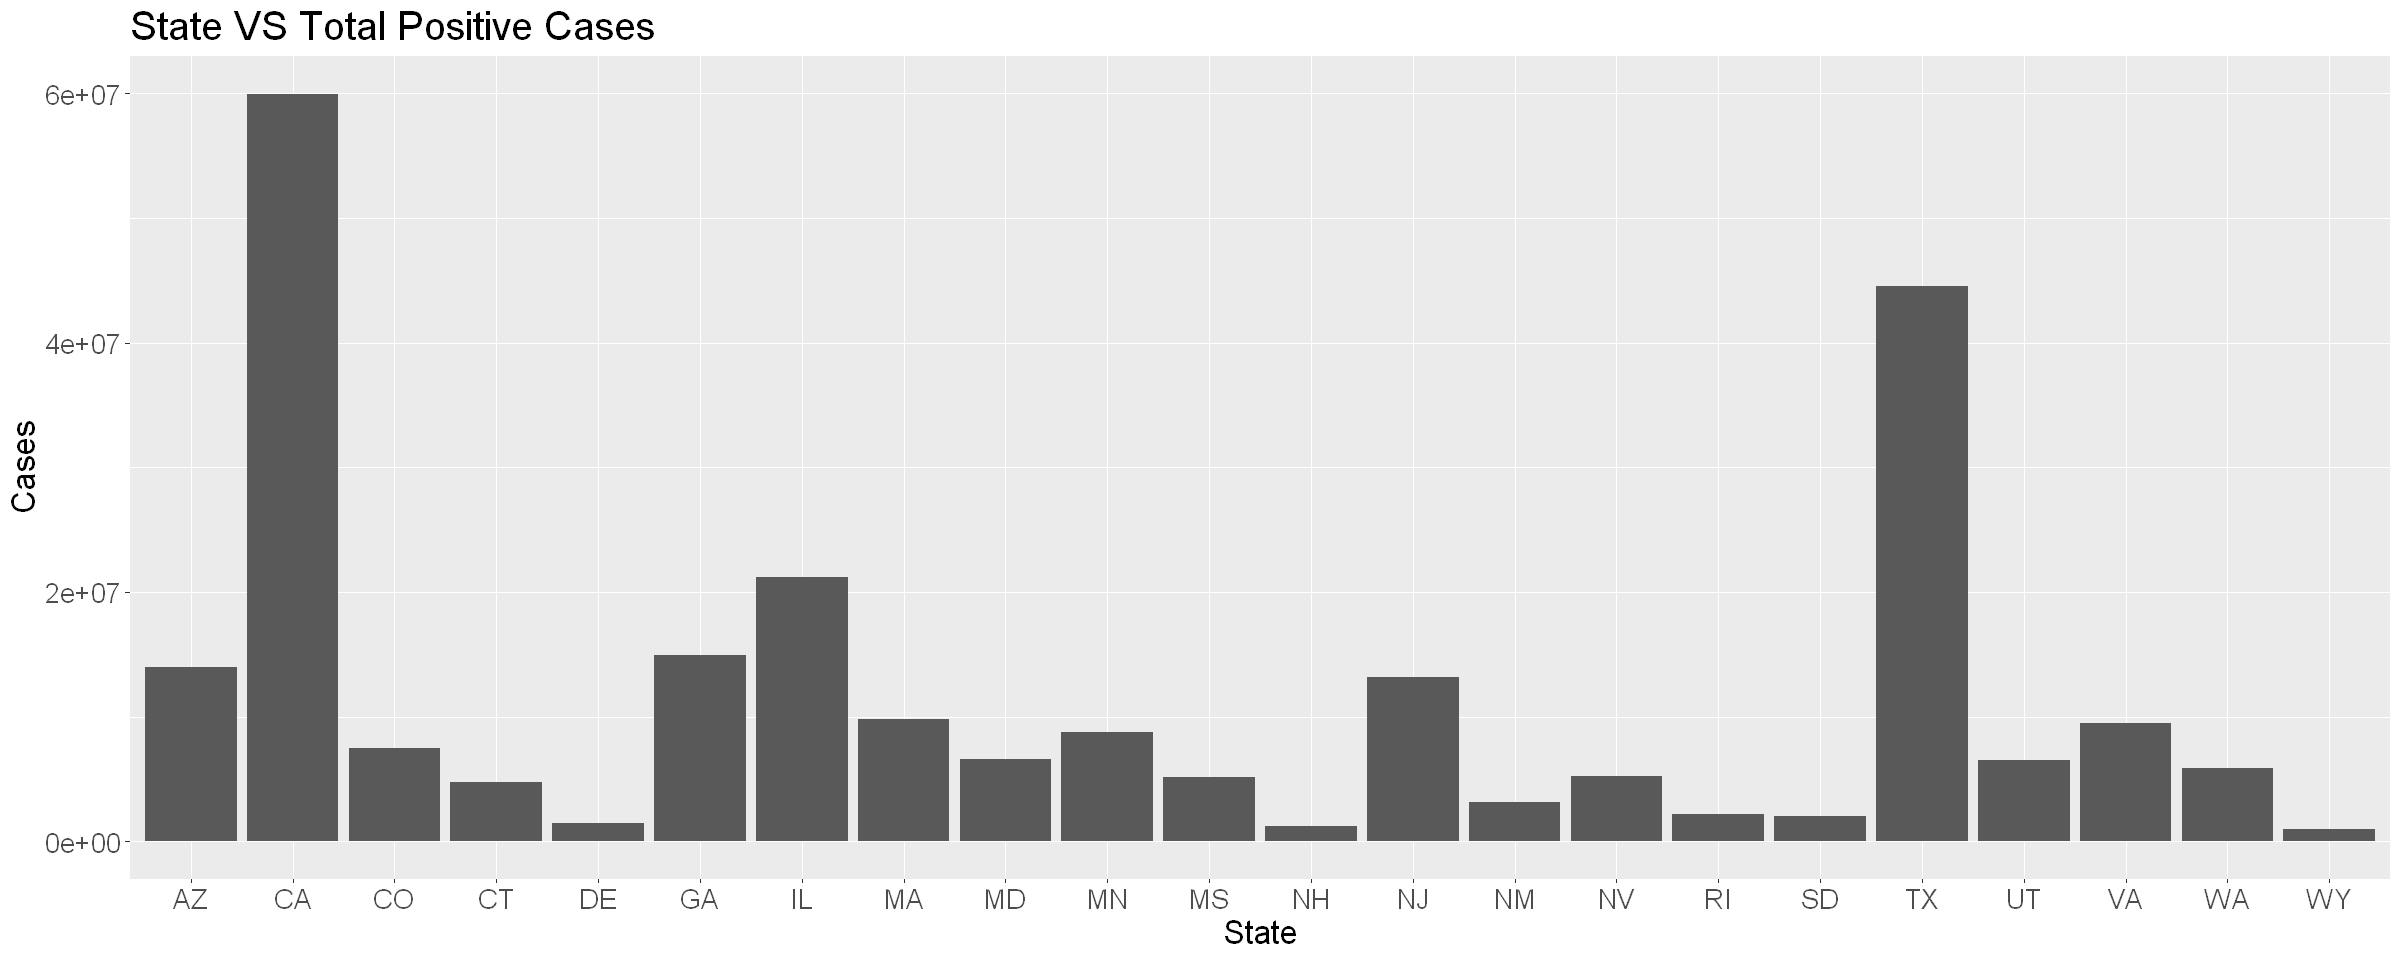

In [11]:
options(repr.plot.width = 20, repr.plot.height = 8)
max_cases <- cases_piped2 %>%
           filter(Year == 2021) %>%
           ungroup() %>%
           select(-Year) %>%
           group_by(State) %>%
           summarize(Cases = sum(Cases_Total)) %>% arrange(desc(Cases))

cases_plot <- ggplot(max_cases, aes(x = State, y = Cases)) + 
              geom_bar(stat = "identity") + 
              labs(title="State VS Total Positive Cases") +
              theme(text = element_text(size = 20))
ggsave("../plots/states-vs-total-pos-cases.png", limitsize = TRUE)

cases_plot

max_cases

In [ ]:
# Focus on twos states WA and 
# tidy_cdc <- Case_Death_Clean %>%
#             filter(State == "WA") %>%
#             summarize(p_white = sum(Cases_White) / sum(Cases_Total),
#                      p_black = sum(Cases_Black) / sum(Cases_Total),
#                      p_Asian = sum(Cases_Asian) / sum(Cases_Total),
#                      p_latin = sum(Cases_Latinx) / sum(Cases_Total),
#                      d_white = sum(Deaths_White) / sum(Deaths_Total),
#                      d_black = sum(Deaths_Black) / sum(Deaths_Total),
#                      d_Asian = sum(Deaths_Asian) / sum(Deaths_Total),
#                      d_latin = sum(Deaths_Latinx) / sum(Deaths_Total))

# tidy_cdc
# Pivoting by deaths? 

# group by races? 




### 2.3 Plot the relevant raw data, tailoring your plot in a way that addresses your question.

In [ ]:
# Plotting raw data

### 2.4 Compute estimates 

*Compute estimates of the parameter you identified across your groups. Present this in a table. If relevant, include these estimates in your plot.*

In [ ]:
# Summary statistics 

## 3. Methods: Plan

### 3.1 What do you expect to find?

Text

### 3.2 What impact could such findings have?

Text

### 3.3 What future questions could this lead to?

Text

## 4. Reference


About the Racial Data Tracker
https://covidtracking.com/race/about